# Load Test Data

In [1]:
# sort values first - binary search 
# distance matrix - rather than for every pair (all-to-all shortest pathes )
# try hashing data structures 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
import scipy.stats as sc
#import shap
#import lime
import sklearn 
import warnings
#import xgboost

import multiprocessing as mp
import time
import pickle 
#import interpret
import collections
import math
import random
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import  RandomForestRegressor
from sklearn.svm import SVC, LinearSVC
from sklearn import preprocessing
#from interpret.glassbox import ExplainableBoostingClassifier
#from interpret import show
from sklearn.preprocessing import LabelEncoder
#from interpret.glassbox import ExplainableBoostingRegressor
#from interpret import show
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import AdaBoostRegressor
%matplotlib inline
import os, sys
#import statsmodels.api as sm
sys.path.append(os.path.abspath("../../../"))

pd.set_option('display.max_columns', None)
#import eli5
#from eli5.sklearn import PermutationImportance



In [2]:
titanic = pd.read_csv('train.csv')
#titanic
full_data = titanic
full_data = full_data.drop(['PassengerId'], axis=1)

import re
deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}
full_data['Cabin'] = full_data['Cabin'].fillna("U0")
full_data['Deck'] = full_data['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
full_data['Deck'] = full_data['Deck'].map(deck)
full_data['Deck'] = full_data['Deck'].fillna(0)
full_data['Deck'] = full_data['Deck'].astype(int)

full_data = full_data.drop('Cabin', axis = 1)

mean = full_data["Age"].mean()
std = full_data["Age"].std()
is_null = full_data["Age"].isnull().sum()
# compute random numbers between the mean, std and is_null
rand_age = np.random.randint(mean - std, mean + std, size = is_null)
# fill NaN values in Age column with random values generated
age_slice = full_data["Age"].copy()
age_slice[np.isnan(age_slice)] = rand_age
full_data["Age"] = age_slice
full_data["Age"] = full_data["Age"].astype(int)
full_data["Age"].isnull().sum()
full_data['Embarked'] = full_data['Embarked'].fillna('S')


full_data['Fare'] = full_data['Fare'].fillna(0)
full_data['Fare'] = full_data['Fare'].astype(int)
full_data = full_data.drop(['Name'], axis=1)
full_data = full_data.drop(['Ticket'], axis=1)
full_data['Sex'] = full_data['Sex'].map({"male": 0, "female": 1})


full_data_train,full_data_test = train_test_split(full_data,test_size = 0.3,random_state = 10)

full_data = pd.get_dummies(full_data,columns = ['Pclass','Embarked','Deck'])
full_data = full_data.dropna().reset_index().drop('index',axis = 1)
X = full_data.drop('Survived',axis = 1)
cols = X.columns
y = full_data['Survived']
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)
X =pd.DataFrame(X, columns = cols)
xTrain, xTest, yTrain, yTest = train_test_split(X,y, test_size = 0.3,random_state = 10)


https://scikit-learn.org/dev/auto_examples/tree/plot_unveil_tree_structure.html

# Model

In [3]:
import itertools
import gc

In [4]:
def get_node_depths(tree1):
    def get_node_depths_(current_node, current_depth, l, r, depths):
        depths += [current_depth]
        if l[current_node] != -1 and r[current_node] != -1:
            get_node_depths_(l[current_node], current_depth + 1, l, r, depths)
            get_node_depths_(r[current_node], current_depth + 1, l, r, depths)
    depths = []
    get_node_depths_(0, 0, tree1.tree_.children_left, tree1.tree_.children_right, depths) 
    return np.array(depths)

def get_shared_nodes(i1,i2,node_indicator, n_nodes):
    sample_ids = [0, 1]
    common_nodes = (node_indicator.toarray()[sample_ids].sum(axis=0) ==
                len(sample_ids))

    common_node_id = np.arange(n_nodes)[common_nodes]
    return common_node_id

# Tree distance between nodes n1, n2 = depth(n1) + depth(n2) - 2 depth(LCA)
def distance_between_samples(indexes,depths,leaves,node_indicator,n_nodes):
    i1 = indexes[0]
    i2 = indexes[1]
    leaf_node1 = leaves[i1]
    leaf_node2 = leaves[i2]
    depth_node1 = depths[leaf_node1]
    depth_node2 = depths[leaf_node2]
    ancestors = get_shared_nodes(i1,i2,node_indicator, n_nodes)
    depth_LCA = max(depths[ancestors])
    #depth_LCA = 0
    dist = depth_node1 + depth_node2 - 2*depth_LCA
    if dist < 0:
        pass
        #print(len(depths))
        #depths[ancestors]
    return dist

In [ ]:
# bootstraps data and builds a tree, then calculates pairwise distances on the data instances relative to the tree
# Tree distance is calculated via lowest common ancestor
def build_tree(xTrain,yTrain,xTest):
    train = xTrain.copy()
    train['y'] = yTrain
    train1 = train.sample(n = len(train), replace = True) 
    yTrain1 = train1['y']
    xTrain1 = train1.drop('y',axis = 1)
    gc.collect()
    estimator = DecisionTreeClassifier().fit(xTrain1,yTrain1)
    n_nodes = estimator.tree_.node_count
    depths = get_node_depths(estimator)
    leaves_train = estimator.apply(xTrain)
    leaves_test = estimator.apply(xTest)
    node_indicator_test = estimator.decision_path(xTest)
    node_indicator_train = estimator.decision_path(xTrain)
    train_comb = list(itertools.combinations(range(0,len(xTrain)), 2))
    test_comb = list(itertools.combinations(range(0,len(xTest)), 2))

    ### Train Distances
    train_distances = []
    for indexes in train_comb:
        dist = distance_between_samples(indexes,depths,leaves_train,node_indicator_train,n_nodes)
        train_distances.append([indexes[0],indexes[1],dist])

    ### Test Distances
    test_distances = []
    for indexes in test_comb:
        dist = distance_between_samples(indexes,depths,leaves_train,node_indicator_test,n_nodes)
        test_distances.append([indexes[0],indexes[1],dist])

    train_dist_df = pd.DataFrame(train_distances, columns = ['i1','i2','tree_dist'])
    test_dist_df = pd.DataFrame(test_distances, columns = ['i1','i2','tree_dist'])
    return([estimator,train_dist_df,test_dist_df, train_comb])

In [60]:
def floyd_warshall(G):
    nV = len(G)
    distance = list(map(lambda i: list(map(lambda j: j, i)), G))

    # Adding vertices individually
    for k in range(nV):
        for i in range(nV):
            for j in range(nV):
                distance[i][j] = min(distance[i][j], distance[i][k] + distance[k][j])
    return distance

In [61]:
def get_tree_dists(estimator):
    n_nodes = estimator.tree_.node_count
    children_left = estimator.tree_.children_left
    children_right = estimator.tree_.children_right

    dists = np.zeros((n_nodes,n_nodes)) 
    for i in range(len(children_left)):
        left_node_id = children_left[i]
        if left_node_id != -1:
            dists[i][left_node_id] = 1
            dists[left_node_id][i] = 1

    for i in range(len(children_right)):
        if children_right[i] != -1:
            dists[i][children_right[i]] = 1
            dists[children_right[i]][i] = 1

    for i in range(n_nodes):
        for j in range(n_nodes):
            if i != j and dists[i][j] == 0:
                dists[i][j] = 1000 # equivalent to infinity because we need distances between ALL ndoes
    return dists

In [66]:
# bootstraps data and builds a tree, then calculates pairwise distances on the data instances relative to the tree
# Tree distance is calculated via lowest common ancestor
def build_tree_fw(xTrain,yTrain,xTest):
    train = xTrain.copy()
    train['y'] = yTrain
    train1 = train.sample(n = len(train), replace = True) 
    yTrain1 = train1['y']
    xTrain1 = train1.drop('y',axis = 1)
    gc.collect()
    estimator = DecisionTreeClassifier().fit(xTrain1,yTrain1)
    n_nodes = estimator.tree_.node_count
    depths = get_node_depths(estimator)
    leaves_train = estimator.apply(xTrain)
    leaves_test = estimator.apply(xTest)
    graph = get_tree_dists(estimator)
    node_indicator_test = estimator.decision_path(xTest)
    node_indicator_train = estimator.decision_path(xTrain)
    train_comb = list(itertools.combinations(range(0,len(xTrain)), 2))
    test_comb = list(itertools.combinations(range(0,len(xTest)), 2))
    dense_path_train = node_indicator_train.toarray()
    graph_train = np.dot(np.transpose(dense_path_train), dense_path_train) #wrong, we want to traverse tree to get distance matrix 
    fw_dist_train = floyd_warshall(graph)
    dense_path_test = node_indicator_test.toarray()
    graph_test = np.dot(np.transpose(dense_path_test), dense_path_test) #wrong
    fw_dist_test = floyd_warshall(graph)
    
    i1_train = [i for i, _ in train_comb]
    i2_train = [i for _, i in train_comb]
    train_dists = [fw_dist_train[leaves_train[i]][leaves_train[j]] for i, j in train_comb]
    train_dist_df = pd.DataFrame(i1_train,columns=['i1'])
    train_dist_df['i2'] = i2_train
    train_dist_df['tree_dist'] = train_dists
    
    i1_test = [i for i, _ in test_comb]
    i2_test = [i for _, i in test_comb]
    test_dists = [fw_dist_test[leaves_test[i]][leaves_test[j]] for i, j in test_comb]
    test_dist_df = pd.DataFrame(i1_test,columns=['i1'])
    test_dist_df['i2'] = i2_test
    test_dist_df['tree_dist'] = test_dists
    
    return([estimator,train_dist_df, test_dist_df])

In [68]:
def fit_random_forest(xTrain,yTrain,num_trees,xTest):
    i = 0
    mods = []
    train_dists = pd.DataFrame()
    test_dists = pd.DataFrame()
    while i <= num_trees:
        tree = build_tree_fw(xTrain,yTrain,xTest)
        mods.append(tree[0])
        train_dists = train_dists.append(tree[1])
        test_dists = test_dists.append(tree[2])
        i = i+1
        
    train_final_dist = train_dists.groupby(['i1','i2']).mean().reset_index()
    test_final_dist = test_dists.groupby(['i1','i2']).mean().reset_index()
    return(mods,train_final_dist,test_final_dist)

def rf_predict(xTest,mods):
    pred = []
    for clf in mods:
        pred.append(clf.predict(xTest))
    pred = np.mean(pred,axis = 0)
    pred = [int(x) for x in pred>=0.5]
    return pred

In [69]:
def rf_predict(xTest,mods):
    pred = []
    for clf in mods:
        pred.append(clf.predict(xTest))
    pred = np.mean(pred,axis = 0)
    pred = [int(x) for x in pred>=0.5]
    return pred


In [70]:
mods,train_final_dist,test_final_dist = fit_random_forest(xTrain,yTrain,100,xTest)

In [71]:
train_final_dist = train_final_dist.groupby(['i1','i2']).mean().reset_index()
test_final_dist = test_final_dist.groupby(['i1','i2']).mean().reset_index()

In [72]:
pred = rf_predict(xTest,mods)
print(np.mean(pred==yTest))

0.8059701492537313


In [73]:
#test_final_dist1

In [74]:
test_final_dist1 = test_final_dist.copy()
test_final_dist1['i1'] = test_final_dist['i2']
test_final_dist1['i2'] = test_final_dist['i1']
test_final_dist = test_final_dist.append(test_final_dist1)

In [75]:
dist = np.zeros(shape = (max(test_final_dist['i1'])+1,max(test_final_dist['i1'])+1))
for i in range(0,len(test_final_dist)):
    temp = test_final_dist.iloc[i]
    i1 = int(temp['i1'])
    i2 = int(temp['i2'])
    tree_dist = temp['tree_dist']
    dist[i1][i2] = tree_dist

In [76]:
dist

array([[ 0.        ,  9.91089109,  9.        , ..., 16.37623762,
        19.64356436, 17.37623762],
       [ 9.91089109,  0.        ,  7.68316832, ..., 18.74257426,
        22.00990099, 19.74257426],
       [ 9.        ,  7.68316832,  0.        , ..., 19.61386139,
        22.88118812, 20.61386139],
       ...,
       [16.37623762, 18.74257426, 19.61386139, ...,  0.        ,
         7.64356436,  7.        ],
       [19.64356436, 22.00990099, 22.88118812, ...,  7.64356436,
         0.        ,  7.25742574],
       [17.37623762, 19.74257426, 20.61386139, ...,  7.        ,
         7.25742574,  0.        ]])

In [77]:
from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters = 3).fit(dist)

/Users/aparnacalambur/anaconda/lib/python3.6/site-packages/scipy/cluster/hierarchy.py:830: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


In [78]:
xTest['clust'] = clustering.labels_

/Users/aparnacalambur/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [79]:
clusters = pd.DataFrame(np.column_stack((yTest,clustering.labels_)),columns = ['y','clust'])

In [80]:
clusters.groupby('clust').mean()

,y
clust,
0,0.738636
1,0.067797
2,0.338710


In [81]:
full_data_test['clust'] = clustering.labels_
clusters = np.unique(clustering.labels_)
clusters

array([0, 1, 2])

0.7386363636363636
0.06779661016949153
0.3387096774193548


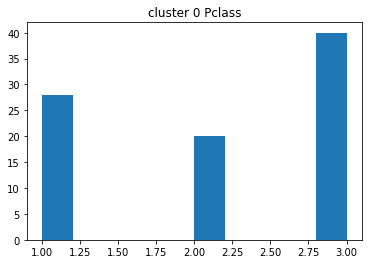

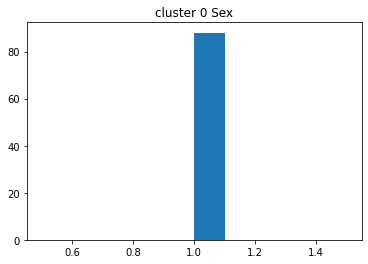

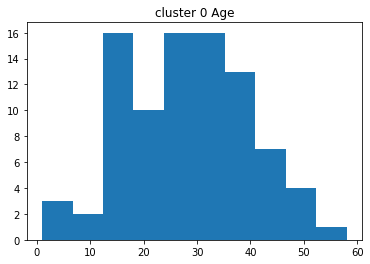

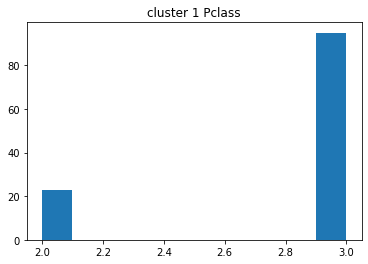

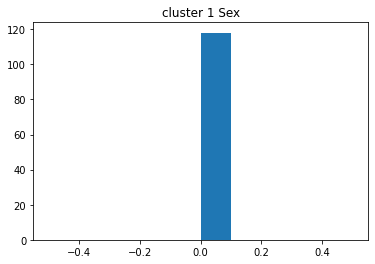

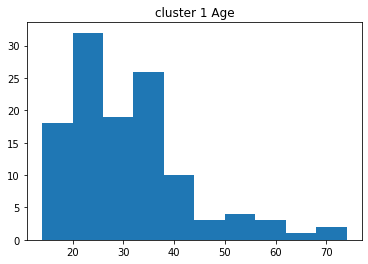

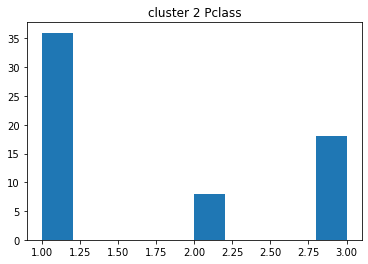

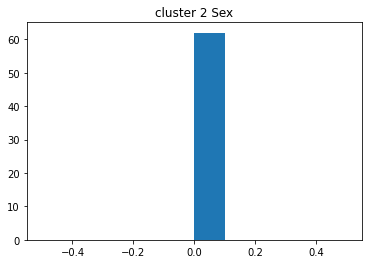

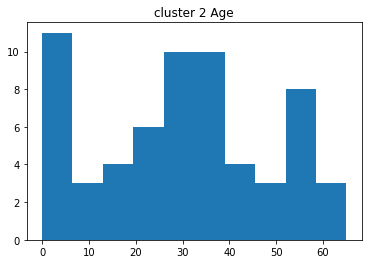

In [82]:
for clust in clusters:
    temp = full_data_test[full_data_test['clust']==clust]
    print(np.mean(temp['Survived']))
    plt.figure()
    plt.title('cluster '+str(clust)+ ' Pclass')
    plt.hist(temp['Pclass'])
    plt.figure()
    plt.title('cluster '+str(clust)+ ' Sex')
    plt.hist(temp['Sex'])
    plt.figure()
    plt.title('cluster '+str(clust)+ ' Age')
    plt.hist(temp['Age'])

In [83]:
full_data_test['clust'] = clustering.labels_
full_data_test[full_data_test['clust']==3]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck,clust


In [84]:
(test_final_dist)

,i1,i2,tree_dist
0,0,1,9.910891
1,0,2,9.000000
2,0,3,15.138614
3,0,4,15.158416
4,0,5,12.089109
...,...,...,...
35773,266,264,9.128713
35774,267,264,7.356436
35775,266,265,7.643564
35776,267,265,7.000000


In [85]:
full_data_test

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck,clust
590,0,3,0,35,0,0,7,S,8,1
131,0,3,0,20,0,0,7,S,8,1
628,0,3,0,26,0,0,7,S,8,1
195,1,1,1,58,0,0,146,C,2,0
230,1,1,1,35,1,0,83,S,3,0
...,...,...,...,...,...,...,...,...,...,...
318,1,1,1,31,0,2,164,S,3,0
863,0,3,1,31,8,2,69,S,8,0
254,0,3,1,41,0,2,20,S,8,0
396,0,3,1,31,0,0,7,S,8,0


In [86]:
train_final_dist.to_csv("train_final_dist.csv")
test_final_dist.to_csv("test_final_dist.csv")
full_data_test.to_csv("full_data_test.csv")

In [87]:
full_data_train.to_csv("full_data_train.csv")

In [ ]:
# pre-set clusters: k-means, tree distance, re-run test metric 
# k-mediods, not pure euclidean distance
# evalutaion process: for each test point, we know each cluster it should be in
# so we are treating cluster as like classification 
# use the cluster id to deterministically determine 
# treat as prediction/classification problem, as bi-product you get a cluster 
# mainly prediction, assuming predictions come from clusters 
# with more clusters, should overfit 
#CV to choose clusters, out of bag ideas for random forest 
# fit 1 forest and fit training set into bag, see which remain and lasso each of those
# no lasso here ??????
# ask brian what the clustering he's looking at does 